# Определение возраста покупателей

Цели:

* Создание таргетированной на определенные возрастные группы системы рекомендаций товаров.
* Проверка возможности контроля добросовестности кассиров при продаже алкоголя при помощи CV.

План работы:

* Проведение исследовательского анализа по набору фотографий.
    * Оценка пригодности датасета для решения поставленных задач.
* Подготовка данные к обучению.
* Обучение нейронной сеть и расчёт её качества.

## Исследовательский анализ данных

In [1]:
import os
import glob
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.applications import Xception
from keras.applications.xception import preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [2]:
pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,
              rc={'lines.linewidth': 1.25})

plt.rcParams.update({'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 6)})

%config InlineBackend.figure_format = 'retina'

Загрузим датафрейм и создадим ImageDataGenerator для выгрузки фото.

In [3]:
path = './datasets/faces/'

labels = pd.read_csv(path + '/labels.csv')
print(labels.shape)
labels.sample()

(7591, 2)


,file_name,real_age
2207,002207.jpg,21


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=38)

Found 7591 validated image filenames.


Построим график распределения возраста в выборке.

* Выборка не слишком большая, что может ограничить точность модели.
* Большинство фото — это молодые люди в возрасте 20-30 лет.
* Видны пики 30-40-50-50-80 лет, что похоже на выбросы. Возможно возраст для части фото округлён.
* В выборке много детей до 5 лет.

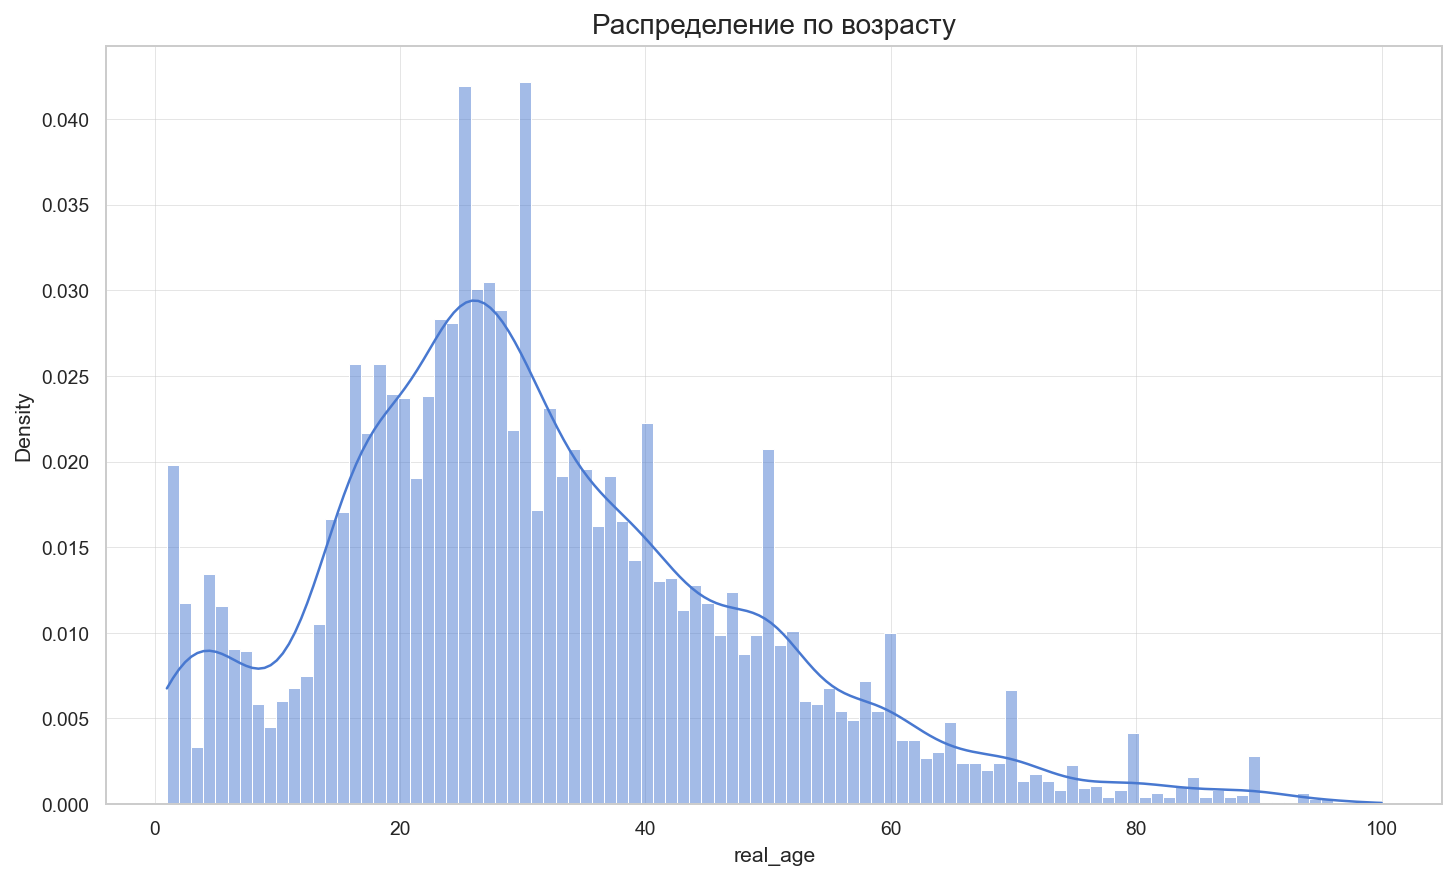

In [5]:
sns.histplot(labels.real_age,
             bins=100,
             stat='density',
             kde=True)
plt.title('Распределение по возрасту', fontsize=14)
plt.show()

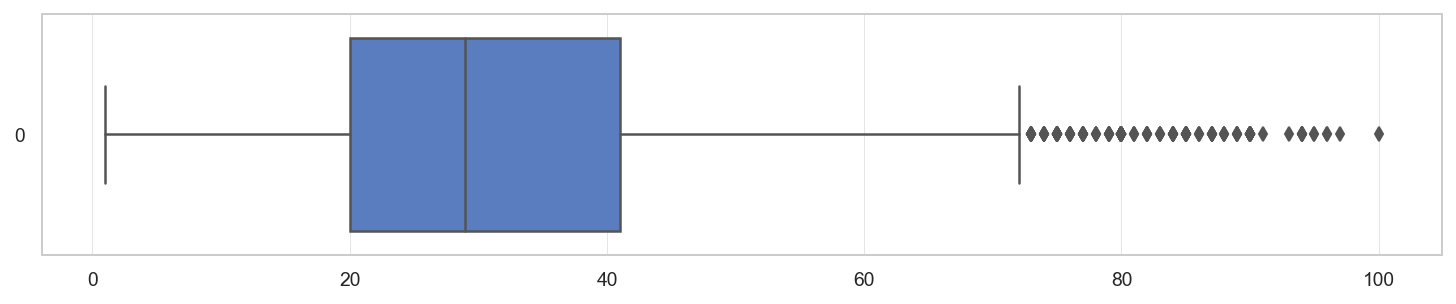

In [6]:
fig = plt.figure(figsize=(10, 2))
sns.boxplot(data=labels.real_age, orient='h');

Выведем на экран фотографии.

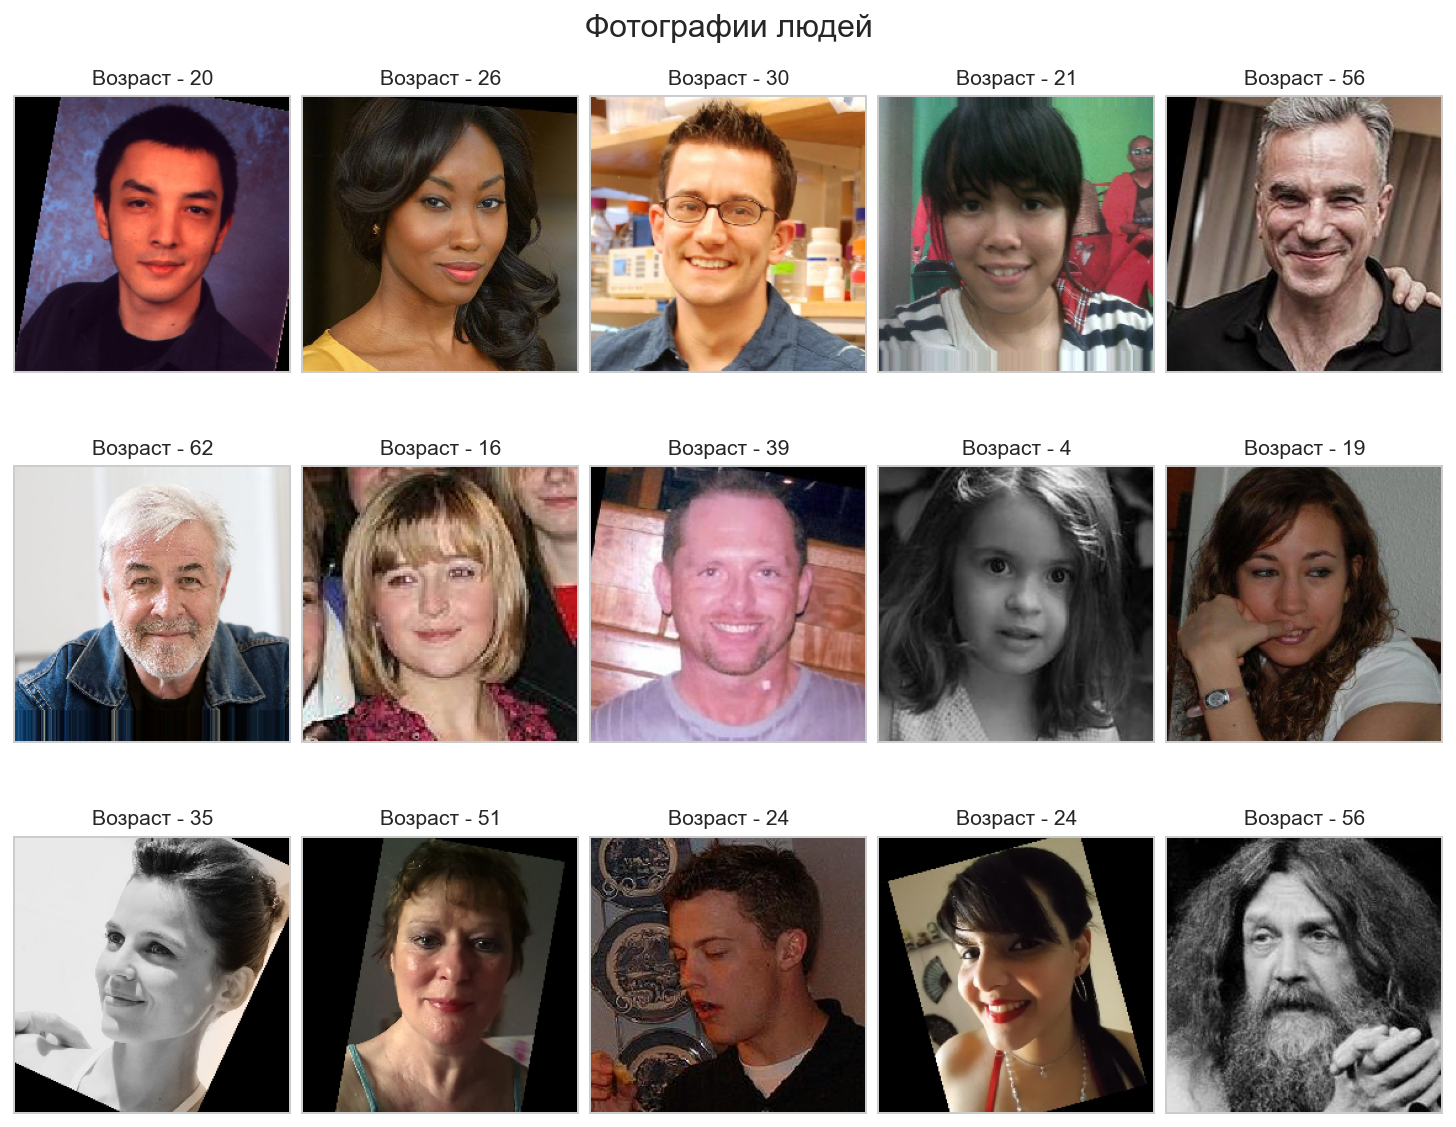

In [7]:
# Возьмем один из батчей.
features, target = next(train_gen_flow)

# Отобразим 15 фотографий.
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Фотографии людей', fontsize=16)
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст - {target[i]}')

    plt.xticks([])
    plt.yticks([])

### Выводы

* В датасете есть ч/б снимки, повернутые снимки и кадры с искажениями.
* Размер фото приведен к (224, 224), оригиналы находятся в диапазоне (60, 60) - (900, 900).
* Присутствуют не только фото лица, но и полноразмерные кадры.
* Данные разнообразны, поэтому можно рассчитывать на хорошее обучение модели.

## Обучение модели

Определим необходимые функции.

In [8]:
# Загрузка тестовой выборки через ImageDataGenerator.
def load_train(path):
    df = pd.read_csv(path + '/labels.csv')

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.25,
        horizontal_flip=True,
        rotation_range=15)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + '/final_files',
        x_col='file_name', y_col='real_age',
        target_size=(299, 299),
        batch_size=10,
        class_mode='raw',
        subset='training',
        shuffle=True,
        seed=38)

    return train_datagen_flow

In [9]:
# Загрузка валидационной выборки через ImageDataGenerator.
def load_test(path):
    df = pd.read_csv(path + '/labels.csv')

    validation_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.25)

    validation_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + '/final_files',
        x_col='file_name', y_col='real_age',
        target_size=(299, 299),
        batch_size=10,
        class_mode='raw',
        subset='validation',
        shuffle=True,
        seed=38)

    return validation_datagen_flow

In [10]:
def create_model(input_shape):
    # Немного уменьшаем шаг обучения.
    optimizer = Adam(learning_rate=0.00005)

    backbone = Xception(input_shape=input_shape,
                        weights='imagenet',
                        pooling='max',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    # model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.15))
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer,
                  loss='mae',
                  metrics=['mae'])

    return model

In [11]:
def train_model(model, train_datagen_flow, validation_datagen_flow,
                batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:        
        steps_per_epoch = len(train_datagen_flow) 
    if validation_steps is None:
        validation_steps = len(validation_datagen_flow)

    model.fit(train_datagen_flow,
              validation_data=validation_datagen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=1)

    return model

Создадим потоки изображений.

In [12]:
train_datagen_flow = load_train(path)

Found 5694 validated image filenames.


In [13]:
validation_datagen_flow = load_test(path)

Found 1897 validated image filenames.


Инициализируем и обучим модель.

In [14]:
try:
    # Восстановление модели из файла, если она доступна.
    model = load_model(path +'/model_age_prediction.h5')
except:
    model = create_model(train_datagen_flow.image_shape)
    model.save(path +'/model_age_prediction.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


In [15]:
model = train_model(model, train_datagen_flow, validation_datagen_flow)

Epoch 1/20
570/570 [==============================] - 102s 168ms/step - loss: 10.4539 - mae: 10.4539 - val_loss: 7.4123 - val_mae: 7.4123
Epoch 2/20
570/570 [==============================] - 95s 167ms/step - loss: 7.2582 - mae: 7.2582 - val_loss: 7.2504 - val_mae: 7.2504
Epoch 3/20
570/570 [==============================] - 97s 170ms/step - loss: 6.3714 - mae: 6.3714 - val_loss: 6.5008 - val_mae: 6.5008
Epoch 4/20
570/570 [==============================] - 96s 169ms/step - loss: 5.6911 - mae: 5.6911 - val_loss: 6.0253 - val_mae: 6.0253
Epoch 5/20
570/570 [==============================] - 97s 170ms/step - loss: 5.1311 - mae: 5.1311 - val_loss: 6.0516 - val_mae: 6.0516
Epoch 6/20
570/570 [==============================] - 97s 170ms/step - loss: 4.9224 - mae: 4.9224 - val_loss: 5.9034 - val_mae: 5.9034
Epoch 7/20
570/570 [==============================] - 97s 170ms/step - loss: 4.4446 - mae: 4.4446 - val_loss: 5.9986 - val_mae: 5.9986
Epoch 8/20
570/570 [==============================] 

## Проверка модели

Загрузим одно из изображений и посмотрим какой возраст предскажет модель.

1/1 [==============================] - 0s 23ms/step


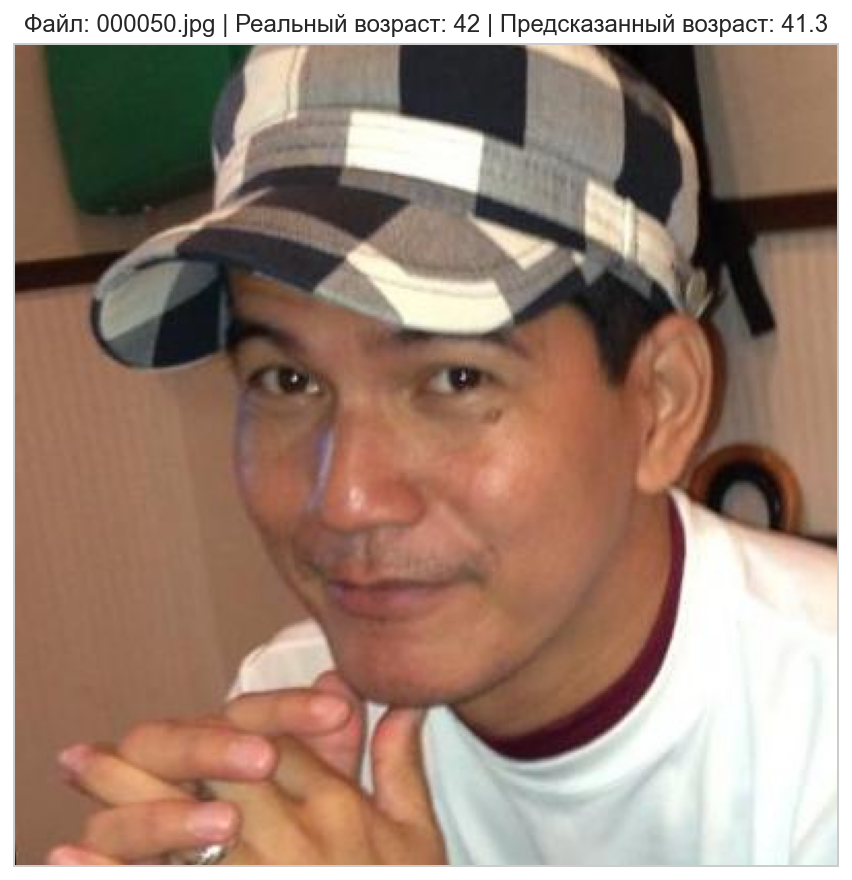

In [16]:
file_path = glob.glob(os.path.join(path + '/final_files/', '*.jpg'))[50]
file_name = os.path.basename(file_path)
img_data = labels.query('file_name == @file_name')

img = Image.open(file_path)
array = np.array(img)

arr2model = tf.image.resize(array, train_datagen_flow.image_shape[:2])
arr2model = preprocess_input(arr2model)
arr2model = np.expand_dims(arr2model, axis=0)
prediction = model.predict(arr2model)[0][0]

plt.imshow(array)
plt.title(f'Файл: {img_data.iat[0,0]} | Реальный возраст: {img_data.iat[0,1]} | Предсказанный возраст: {prediction:.1f}',
          fontdict={'size': 12})
plt.xticks([])
plt.yticks([])
plt.show()

Построим разницу между предсказанным значением возраста и реальным, чтобы оценить как модель показывает себя для различных возрастных групп.

In [17]:
res = []
for _ in range(len(validation_datagen_flow)):
    X, y = next(validation_datagen_flow)
    y_hat = model.predict(X, verbose=0).flatten()
    for i in range(10):
        try:
            res.append([y[i], y_hat[i]])
        except:
            None
            
res_df = pd.DataFrame(res, columns=['real_age', 'pred_age'])
res_df['delta'] = res_df.real_age - res_df.pred_age

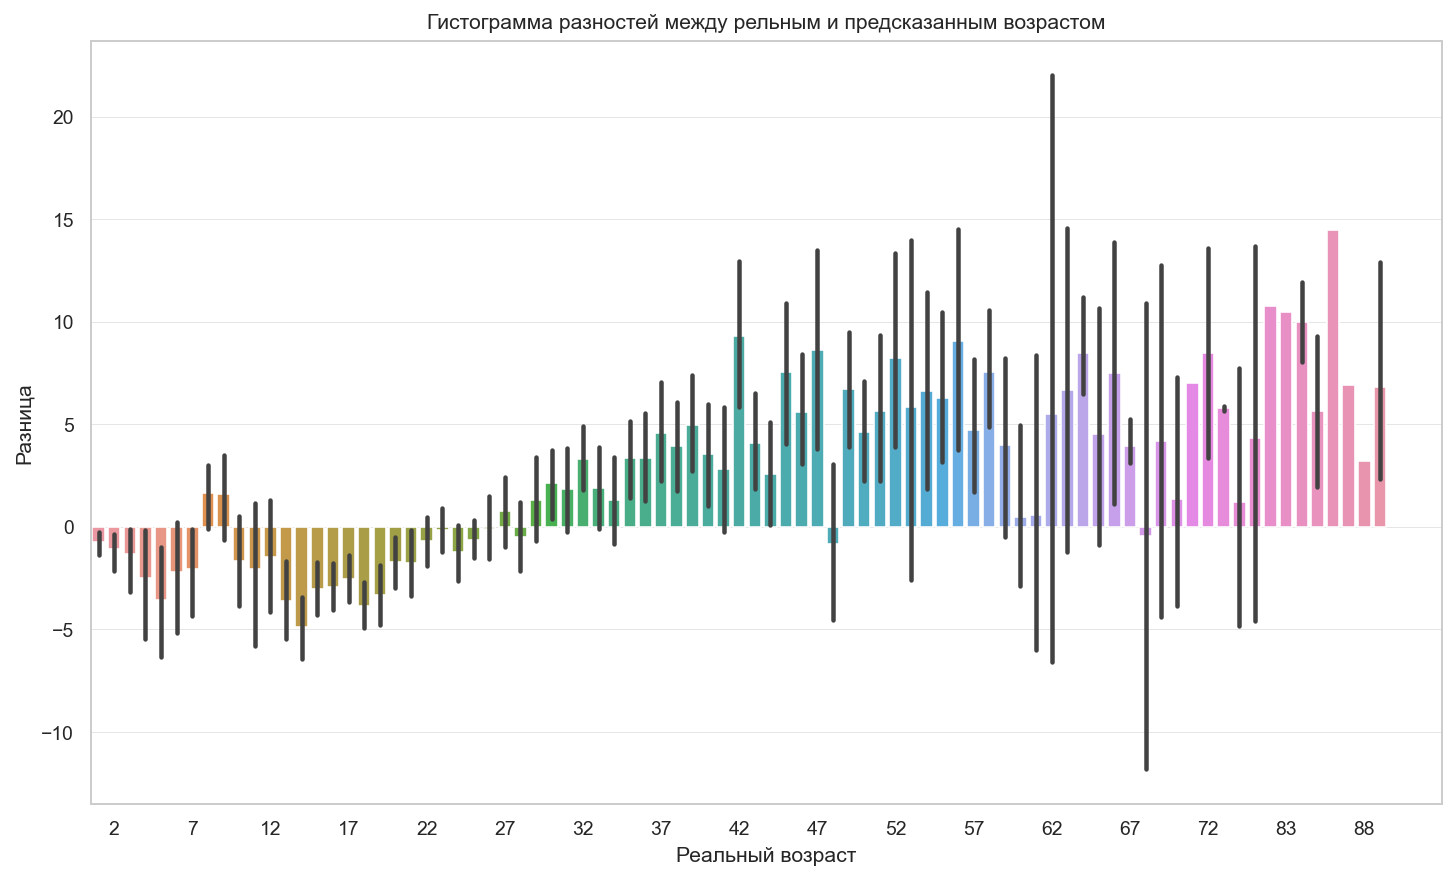

In [18]:
g = sns.barplot(data=res_df, x='real_age', y='delta')
g.set_title('Гистограмма разностей между рельным и предсказанным возрастом')
g.set_xlabel('Реальный возраст')
g.set_ylabel('Разница')
g.set_xticks(range(res_df.real_age.min(), res_df.real_age.max(),5));

## Анализ обученной модели

* В результате анализа лучшей моделью стала Xception, MAE составил 5.22.
* Чтобы улучшить предсказание использованы техники аугментации horizontal_flip, rotation_range и Dropout слой.
* Модель может быть использована для таргетирования, но не для контроля добросовестности кассиров (разброс слишком велик).